### Test-drive PyMC3

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm

from scipy import optimize

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
tickers = ['aapl', 'amd',] # 'msft', 'intc'] #, 'd', 'sbux', 'atvi',]
#           'ibm', 'ual', 'vrsn', 't', 'mcd', 'vz']

In [3]:
dataframes = [pd.read_csv('../iexfinance/iexdata/{}'.format(str.upper(ticker)))
             for ticker in tickers]
price_deltas = [ticker.close.pct_change().shift(-1).dropna()[:1000]
               for ticker in dataframes]

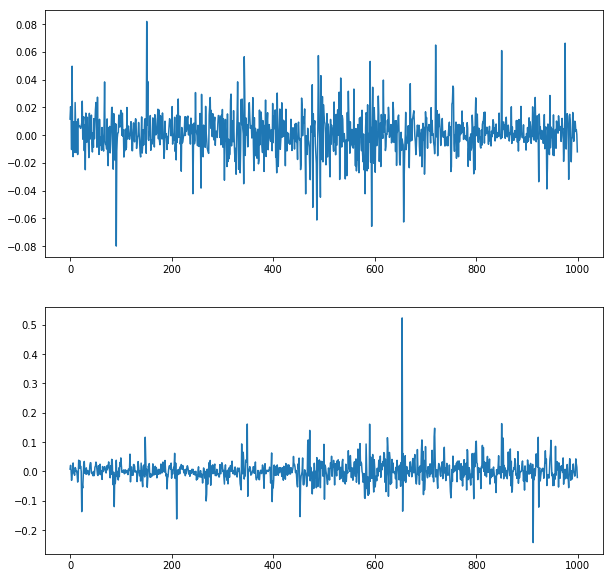

In [27]:
fig, axes = plt.subplots(len(tickers), figsize=(10, 10))
_ = [ax.plot(price_delta) for ax, price_delta in zip(axes, price_deltas)]

In [28]:
from pymc3.distributions import GaussianRandomWalk

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, s, sigma]
Sampling 4 chains: 100%|██████████| 12000/12000 [10:51<00:00,  4.89draws/s]
The acceptance probability does not match the target. It is 0.8121898293645966, but should be close to 0.9. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


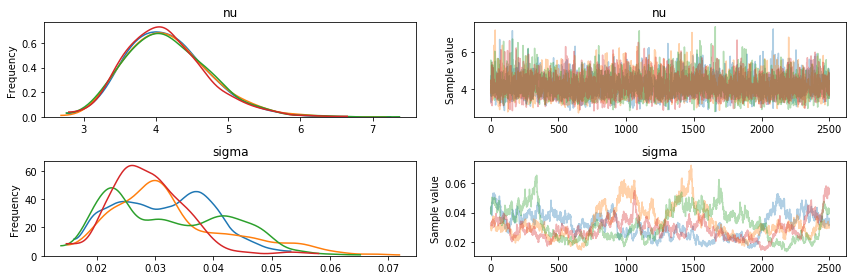

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, s, sigma]
Sampling 4 chains: 100%|██████████| 12000/12000 [07:16<00:00,  8.51draws/s]
The acceptance probability does not match the target. It is 0.6586983800175161, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.4510989141235104, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5546131042634644, but should be close to 0.9. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


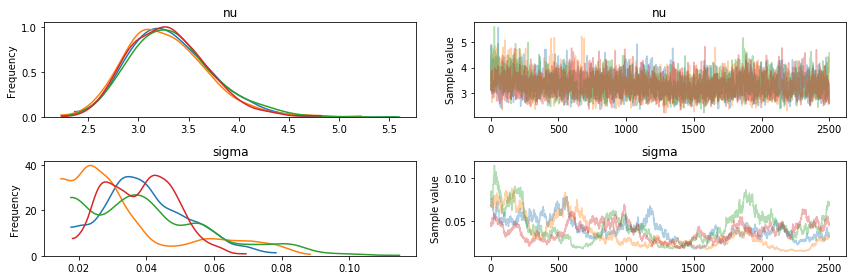

In [29]:
def run_model(deltas):
    traces = []
    for delta in deltas:
        with pm.Model() as model:
            # Let's just try the one in pymc3 official
            sigma = pm.Exponential('sigma', 50.)
            s = GaussianRandomWalk('s', sd=sigma,
                                   shape=len(delta))

            nu = pm.Exponential('nu', .1)

            r = pm.StudentT('r', nu=nu,
                            lam=pm.math.exp(-2*s),
                            observed=delta)
            
            trace = pm.sample(2500, nuts_kwargs=dict(target_accept=.9))
            traces.append(trace)
            
            pm.traceplot(trace, varnames=['nu', 'sigma'])
            plt.show();
    return traces

traces = run_model(price_deltas)

### MCMC is really slow... plus may NOT CONVERGE. If sample size large enough, just use MLE. Well, MLE is a uniform prior of MAP anyway... so doesn't matter

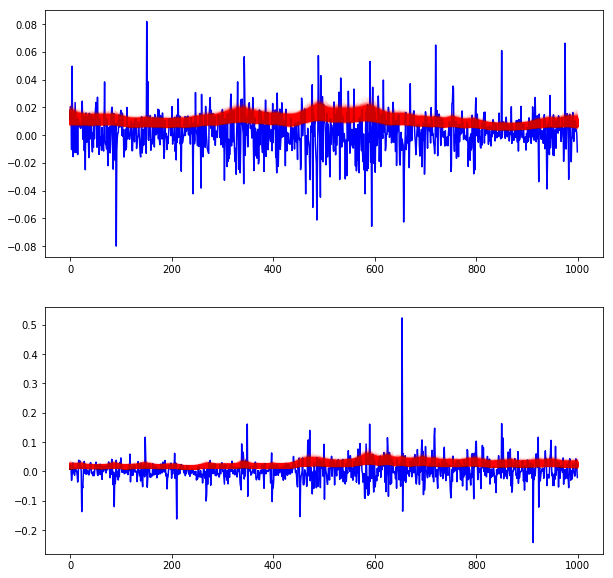

In [30]:
def plot_price_vol(axis, price_delta, trace):
    axis.plot(price_delta, 'b')
    axis.plot(np.exp(trace['s'].T), 'r', alpha=0.02)

fig, axes = plt.subplots(len(tickers), figsize=(10, 10))
_ = [plot_price_vol(ax, price_delta, trace) 
     for ax, price_delta, trace in zip(axes, price_deltas, traces)]

### An awesome chapter about [Covariance functions/kernels](http://www.gaussianprocess.org/gpml/chapters/RW4.pdf)

### Try neural networks, and make a Bayesian Model

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import numpy as np
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from edward.models import Normal, Poisson
from observations import celegans

In [2]:
tickers = ['aapl', 'amd', 'msft', 'intc', 'd', 'sbux', 'atvi',
          'ibm', 'ual', 'vrsn', 't', 'mcd', 'vz']
dataframes = [pd.read_csv('../iexfinance/iexdata/{}'.format(str.upper(ticker)))
             for ticker in tickers]
price_deltas = [ticker.close.pct_change().shift(-1).dropna()[:1000]
               for ticker in dataframes]

In [32]:
sine_wave = pd.Series(np.sin(np.linspace(-np.pi, np.pi, 100)))

In [33]:
def get_stacked_data(one_series, time_steps=5):
    stacks = []
    for t in range(time_steps):
        stacks.append(one_series.shift(-t))
    # This leaves trailing nan
    return np.stack(stacks, axis=1)

In [34]:
def train_test(one_series, time_steps=5):
    length = len(one_series)
    train_index = int(length*0.8)
    
    stacked_data = get_stacked_data(one_series, time_steps)
    
    x_train = stacked_data[:train_index, :-1]
    y_train = stacked_data[:train_index,  -1]
    
    x_test = stacked_data[train_index: -time_steps, :-1]
    y_test = stacked_data[train_index: -time_steps,  -1]
    
    return x_train, y_train, x_test, y_test

In [35]:
x_train, y_train, x_test, y_test = train_test(sine_wave)

In [37]:
X = tf.placeholder(tf.float32, [None, 4])
w = Normal(loc=tf.zeros(4), scale=tf.ones(4))
b = Normal(loc=tf.zeros(1), scale=tf.ones(1))
loc = ed.dot(X, w) + b
y = Normal(loc=loc, scale=tf.ones_like(loc))

In [38]:
sess = ed.get_session()
tf.global_variables_initializer().run()
sess_y = sess.run(y, feed_dict={X:x_train})

In [12]:
sess_y.shape

(800,)

In [8]:
qw = Normal(loc=tf.get_variable("w_loc", [4]),
            scale=tf.nn.softplus(tf.get_variable("w_scale", [4])))
qb = Normal(loc=tf.get_variable("b_loc", [1]),
            scale=tf.nn.softplus(tf.get_variable("b_scale", [1])))

In [16]:
inference = ed.KLqp({w: qw, b: qb}, data={X: x_train, y: y_train})

/home/wbaik/.conda/envs/tf16/lib/python3.5/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


In [39]:
inference.run(n_samples=64, n_iter=2000)

2000/2000 [100%] ██████████████████████████████ Elapsed: 41s | Loss: 738.999


In [21]:
# print(ed.evaluate('mean_squared_error', data={X: X_train, y: y_train}))
print(ed.evaluate('mean_absolute_error', data={X: x_train, y: y_train}))

/home/wbaik/.conda/envs/tf16/lib/python3.5/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


0.08297363


In [19]:
sess.run(qw.mean())

array([-0.01105333, -0.01013988, -0.00210226,  0.00888743], dtype=float32)